#### Objective

In this notebook I introduce a function to despike logs using rolling statistics to define the what constitutes a spike, and what does not.

I will apply the despiking to the P-wave velocity from one of the wells already used in the [Backusfrom dataframe notebook](https://github.com/mycarta/in-bruges/blob/master/notebooks/Backus_from_dataframe.ipynb).


#### Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage.morphology import binary_dilation
from welly import Project, Well
import matplotlib.pyplot as plt

#### Import well

In [2]:
R39 = Well.from_las('../data/R-39.las')

#### Data clean-up and manipulation

- Make dataframe
- Deal with null values
- Select columns of interest
- Convert slowness to velocity
- Add well name column

Make dataframe

In [3]:
w39_df = R39.df()
w39_df = w39_df[['DT4P', 'DT4S', 'RHOB']]
w39_df.columns = ['DT', 'DTS', 'RHOB']
w39_df.describe(include = 'all')

,DT,DTS,RHOB
count,7843.000000,7843.000000,7843.000000
mean,279.843323,455.340913,2493.556531
std,25.963527,439.113290,114.662210
min,166.347500,-3278.379200,2050.229000
25%,262.778350,461.351100,2450.387250
50%,284.251700,515.766000,2505.075000
75%,299.587350,555.725100,2569.123050
max,348.946300,590.522000,3144.669700


Checking well R-39 for null values

In [4]:
for x in w39_df.columns:
    print (x, w39_df[x].isnull().values.any())
    
print(w39_df.isnull().sum()) # finds how many missing points there are

DT False
DTS False
RHOB False
DT      0
DTS     0
RHOB    0
dtype: int64


There are no null values.

Convert slowness to velocity (usec/m >> m/s)

In [5]:
w39_df['Vp'] = 1.0e6 / w39_df['DT'] 
w39_df['Vs'] = 1.0e6 / w39_df['DTS'] 
w39_df.describe(include = 'all')

,DT,DTS,RHOB,Vp,Vs
count,7843.000000,7843.000000,7843.000000,7843.000000,7843.000000
mean,279.843323,455.340913,2493.556531,3607.216564,1977.281811
std,25.963527,439.113290,114.662210,367.703324,377.646396
min,166.347500,-3278.379200,2050.229000,2865.770464,-305.028778
25%,262.778350,461.351100,2450.387250,3337.924649,1791.625370
50%,284.251700,515.766000,2505.075000,3518.008863,1932.638279
75%,299.587350,555.725100,2569.123050,3805.488542,2141.848409
max,348.946300,590.522000,3144.669700,6011.512046,3392.929000


Add well name column

In [6]:
w39_df['DEPTH'] = w39_df.index
w39_df['well'] = 'R-39'
w39_df = w39_df.reset_index(drop=True)
w39_df.describe(include = 'all')

,DT,DTS,RHOB,Vp,Vs,DEPTH,well
count,7843.000000,7843.000000,7843.000000,7843.000000,7843.000000,7843.000000,7843
unique,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,NaN,NaN,R-39
freq,NaN,NaN,NaN,NaN,NaN,NaN,7843
mean,279.843323,455.340913,2493.556531,3607.216564,1977.281811,2790.596400,NaN
std,25.963527,439.113290,114.662210,367.703324,377.646396,345.067648,NaN
min,166.347500,-3278.379200,2050.229000,2865.770464,-305.028778,2193.036000,NaN
25%,262.778350,461.351100,2450.387250,3337.924649,1791.625370,2491.816200,NaN
50%,284.251700,515.766000,2505.075000,3518.008863,1932.638279,2790.596400,NaN
75%,299.587350,555.725100,2569.123050,3805.488542,2141.848409,3089.376600,NaN


Drop slownness columns, sort columns

In [7]:
w39_df.drop(w39_df.columns[[0, 1]], inplace=True, axis=1) 
w39_df = w39_df[['DEPTH', 'Vp', 'Vs', 'RHOB', 'well']]    
w39_df.describe(include = 'all')

,DEPTH,Vp,Vs,RHOB,well
count,7843.000000,7843.000000,7843.000000,7843.000000,7843
unique,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,R-39
freq,NaN,NaN,NaN,NaN,7843
mean,2790.596400,3607.216564,1977.281811,2493.556531,NaN
std,345.067648,367.703324,377.646396,114.662210,NaN
min,2193.036000,2865.770464,-305.028778,2050.229000,NaN
25%,2491.816200,3337.924649,1791.625370,2450.387250,NaN
50%,2790.596400,3518.008863,1932.638279,2505.075000,NaN
75%,3089.376600,3805.488542,2141.848409,2569.123050,NaN


#### Despiking

Get P-wave velocity as an array

In [8]:
s=w39_df['Vp'].values

Despiking function

In [9]:
def despike(s, w, stds):
    """
    Despikes a curve using rolling statistics.
    First, it calculates the rolling median of the input curve on a long window. 
    Next, it calculates the difference between the median and the input.
    Finally, it replaces the input with the median if their difference exceeds the mean difference 
    plus a user defined number of standard deviations of the difference.
    Args:
        s = input curve (ndarray)
        w = long window length for the rolling median filter (integer)
        std = the number of standard deviations to use to flag spikes (integer)
        Returns:
        out (ndarray) =  despiked curve
    """
    
    m = pd.Series(s).rolling(window=w, center=True).median()
    flag = np.where(error_flag(pd.Series(s), m, dev = stds)==1)
    out = np.copy(s)
    out[flag] = m.values[flag]
    return out

In [10]:
def rolling_despike(s, w1=75, w2=9, dev=4, dil=29):
    """
    Despikes a curve using rolling statistics.
    First, it calculates the rolling median of the input curve on a long window. 
    Next, it calculates the difference between the median and the input.
    Finally, it replaces the input with the median if their difference exceeds the mean difference 
    plus a user defined number of standard deviations of the difference.
    Args:
        s = input curve (ndarray)
        w = long window length for the rolling median filter (integer)
        std = the number of standard deviations to use to flag spikes (integer)
        Returns:
        out (ndarray) =  despiked curve
    """
    s = pd.Series(s)
    mdn = s.rolling(window=w1,  min_periods=1, center=True).apply(lambda x : np.nanmedian(x), 'raw=True')
    s_mdn = s.rolling(window=w2,  min_periods=1, center=True).apply(lambda x : np.nanmedian(x), 'raw=True')
    mdn_mdn = mdn.rolling(window=w2,  min_periods=1, center=True).apply(lambda x : np.nanmedian(x), 'raw=True')

    flag = np.where(error_flag(s_mdn, mdn_mdn, dev, dil)==1)
   
    out = np.copy(s)
    out[flag] = mdn.values[flag]
    return out

In [11]:
def error_flag(pred, actual, dev, dil):
    """
    Calculate the difference between a predicted and an actual curve 
    and return a log flagging large differences based on a user-defined distance 
    (in standard deviation units) from the mean difference
    Matteo Niccoli, October 2018   
    Args:
        predicted (ndarray) = predicted log
        actual (ndarray) =  original log  
        dev  (float) = standard deviations to use, default 1
    Returns:
    flag (ndarray) =  error flag curve
    """ 
    
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    flag[np.where(err>(err_mean + (dev*err_std)))] = 1
    flag=binary_dilation(flag, np.ones(dil))*1
    return flag

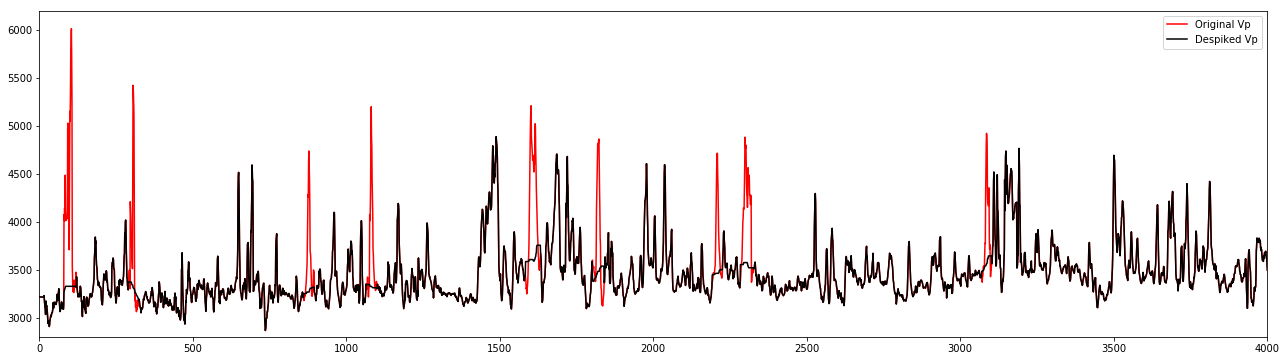

In [12]:
plt.figure(figsize=(22,6))
plt.plot(s, 'r', label='Original Vp')
plt.plot(rolling_despike(s), 'k', label='Despiked Vp')
plt.ylim(2800,6200)
plt.xlim(0,4000)
plt.legend();

## Compare to Welly despike

In [13]:
def rolling_window(s, window_length, func1d, step=1, return_rolled=False):
	    """
	    Private function. Smoother for other smoothing/conditioning functions.
	
	    Args:
	        window_length (int): the window length.
	        func1d (function): a function that takes a 1D array and returns a
	        scalar.
	        step (int): if you want to skip samples in the shifted versions.
	        Don't use this for smoothing, you will get strange results.
	
	    Returns:
	        ndarray: the resulting array.
	    """
	    # Force odd.
	    if window_length % 2 == 0:
	        window_length += 1
	
	    shape = s.shape[:-1] + (s.shape[-1], window_length)
	    strides = s.strides + (step*s.strides[-1],)
	    data = np.nan_to_num(s)
	    data = np.pad(data, int(step*window_length//2), mode='edge')
	    rolled = np.lib.stride_tricks.as_strided(data,
	                         shape=shape,
	                         strides=strides)
	    result = np.apply_along_axis(func1d, -1, rolled)
	    result[np.isnan(s)] = np.nan
	
	    if return_rolled:
	        return result, rolled
	    else:
	        return result
	
def despike(s, window_length=45, samples=True, z=2):
	    """
	    Args:
	    window (int): window length in samples. Default 33 (or 5 m for
	    most curves sampled at 0.1524 m intervals).
	    samples (bool): window length is in samples. Use False for a window
	    length given in metres.
	    z (float): Z score
	
	    Returns:
	    Curve.
	    """
	    window_length //= 1 if samples else s.step
	    z *= np.nanstd(s)  # Transform to curve's units
	    curve_sm = rolling_window(s,window_length, np.median)
	    spikes = np.where(np.nan_to_num(s - curve_sm) > z)[0]
	    spukes = np.where(np.nan_to_num(curve_sm - s) > z)[0]
	    out = np.copy(s)
	    np.copy(s)
	    out[spikes] = curve_sm[spikes] + z
	    out[spukes] = curve_sm[spukes] - z
	    return out


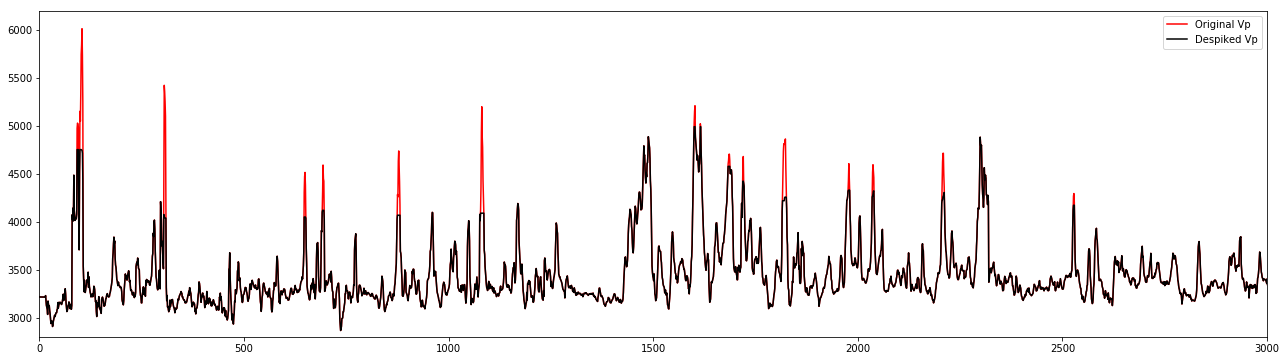

In [14]:
plt.figure(figsize=(22,6))
plt.plot(s, 'r', label='Original Vp')
plt.plot(despike(s), 'k', label='Despiked Vp')
plt.ylim(2800,6200)
plt.xlim(0,3000)
plt.legend();
